The task for this project is to build a GAN that generates 7,000 to 10,000 Monet-style images.

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. In this case, we will generate images in the style of Monet, and train the generator using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Files:

1) monet_jpg - 300 Monet paintings sized 256x256 in JPEG format

2) monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format

3) photo_jpg - 7028 photos sized 256x256 in JPEG format

4) photo_tfrec - 7028 photos sized 256x256 in TFRecord format


In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
from kaggle_datasets import KaggleDatasets

from colorama import Fore, Back, Style
from tensorflow import keras
from tensorflow.keras import layers

import PIL

AUTOTUNE = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.6.4


### Overview/Explanation of GAN/CycleGAN: 

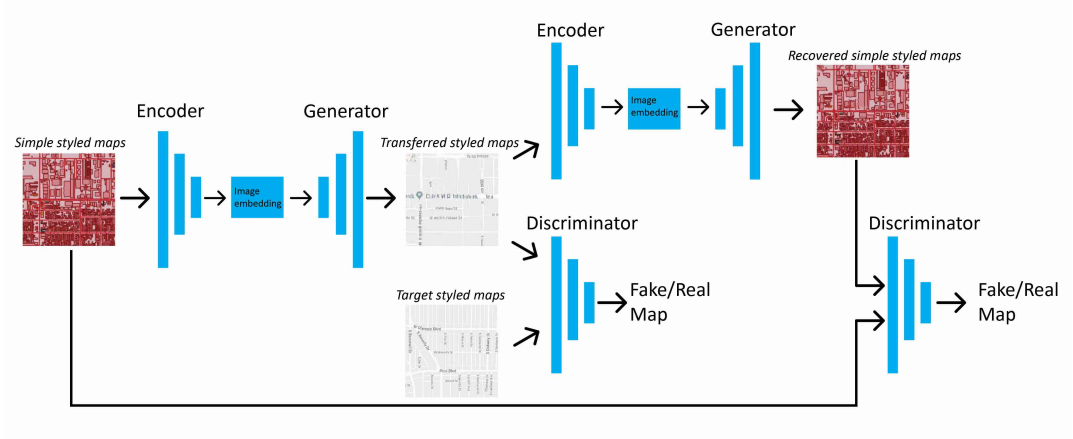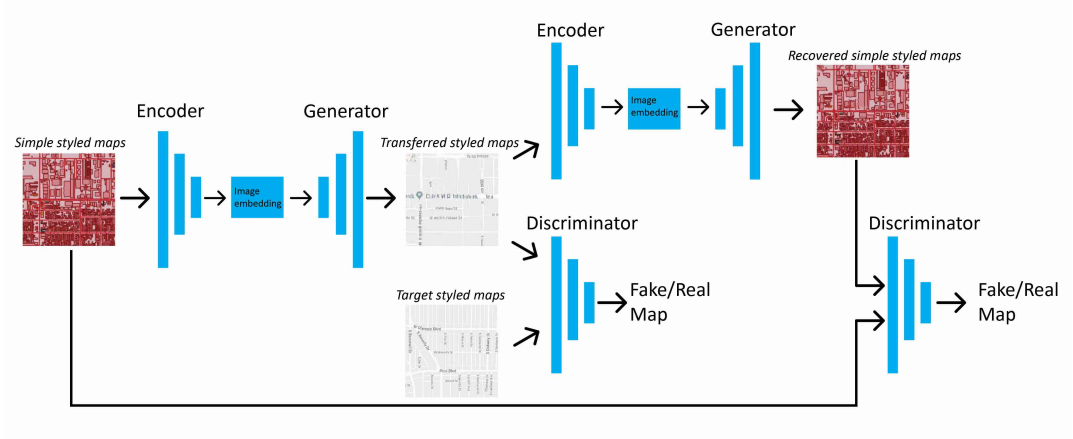

CycleGAN is an approach to training image-to-image translation models using the generative adversarial network, or GAN, model architecture. The GAN architecture is an approach to training a model for image synthesis that is comprised of two models: a generator model and a discriminator model. The generator takes a point from a latent space as input and generates new plausible images from the domain, and the discriminator takes an image as input and predicts whether it is real (from a dataset) or fake (generated). Both models are trained in a game, such that the generator is updated to better fool the discriminator and the discriminator is updated to better detect generated images.

The CycleGAN is an extension of the GAN architecture that involves the simultaneous training of two generator models and two discriminator models.

One generator takes images from the first domain as input and outputs images for the second domain, and the other generator takes images from the second domain as input and generates images for the first domain. Discriminator models are then used to determine how plausible the generated images are and update the generator models accordingly.

Citation:

https://machinelearningmastery.com/what-is-cyclegan/

#### Load in the data:

In [2]:
FULL_PATH = KaggleDatasets().get_gcs_path()

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(FULL_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(FULL_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

2022-10-11 17:55:24.297757: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

2022-10-11 17:55:26.030227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 17:55:26.139103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 17:55:26.139952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 17:55:26.141359: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
ex_monet = next(iter(monet_ds))
ex_photo = next(iter(photo_ds))

2022-10-11 17:55:28.951754: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


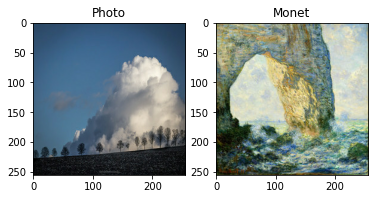

In [7]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(ex_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(ex_monet[0] * 0.5 + 0.5)

#### We will first create the blocks necessary to construct the CycleGAN. I used the following two articles as reference in order to further understand the CycleGAN model, and help me construct the blocks and the actual CycleGAN model:

1)https://keras.io/examples/generative/cyclegan/#:~:text=CycleGAN%20is%20a%20model%20that,examples%20isn't%20always%20feasible.

2)https://www.tensorflow.org/tutorials/generative/cyclegan#:~:text=CycleGAN%20uses%20a%20cycle%20consistency,the%20source%20and%20target%20domain.

In [8]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

#### Construct the Generator:

In [9]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
        upsample(256, 4), 
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#### Construct the Discriminator:

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

#### Cycle Consistency:

The CycleGAN uses an additional extension to the architecture called cycle consistency, where an image output by the first generator could be used as input to the second generator and the output of the second generator should match the original image. The reverse is also true: that an output from the second generator can be fed as input to the first generator and the result should match the input to the second generator.

Now, we will define the two generators and two discriminators. The "Monet Generator" will transform photos to Monet-style paintings, while the "Photo Generator" will perform the opposite task. Similarly, the "Monet Discriminator" will differentiate real Monet paintings and generated Monet paintings, while the "Photo Discriminator" will differentiate real photos and generated photos:

In [11]:
with strategy.scope():
    monet_generator = Generator() 
    photo_generator = Generator() 

    monet_discriminator = Discriminator() 
    photo_discriminator = Discriminator() 

#### Build the actual CycleGAN Model:

In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Revisiting the idea of cycle consistency, The CycleGAN encourages cycle consistency by adding an additional loss to measure the difference between the generated output of the second generator and the original image, and the reverse. This acts as a regularization of the generator models, guiding the image generation process in the new domain toward image translation.

#### Construct the Loss Functions:

In [13]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [14]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [15]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [16]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### Train the Model:

In [17]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )
    
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

Epoch 1/10


2022-10-11 17:56:21.321036: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


300/300 [==============================] - 129s 260ms/step - monet_gen_loss: 5.2560 - photo_gen_loss: 5.4388 - monet_disc_loss: 0.6411 - photo_disc_loss: 0.6150
Epoch 2/10
300/300 [==============================] - 82s 261ms/step - monet_gen_loss: 3.6745 - photo_gen_loss: 3.7790 - monet_disc_loss: 0.6673 - photo_disc_loss: 0.6301
Epoch 3/10
300/300 [==============================] - 81s 258ms/step - monet_gen_loss: 3.6072 - photo_gen_loss: 3.7148 - monet_disc_loss: 0.6492 - photo_disc_loss: 0.6216
Epoch 4/10
300/300 [==============================] - 83s 263ms/step - monet_gen_loss: 3.4982 - photo_gen_loss: 3.5699 - monet_disc_loss: 0.6396 - photo_disc_loss: 0.6248
Epoch 5/10
300/300 [==============================] - 82s 260ms/step - monet_gen_loss: 3.3308 - photo_gen_loss: 3.4049 - monet_disc_loss: 0.6313 - photo_disc_loss: 0.6176
Epoch 6/10
300/300 [==============================] - 82s 261ms/step - monet_gen_loss: 3.2216 - photo_gen_loss: 3.2824 - monet_disc_loss: 0.6235 - photo_di

#### Visualize the Images:

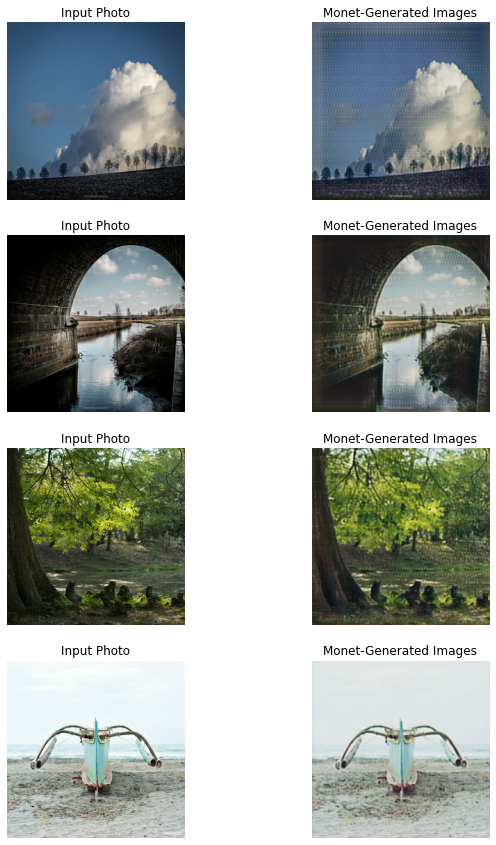

In [18]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(photo_ds.take(4)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-Generated Images")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [19]:
#! mkdir ../images
#i = 1
#for img in photo_ds:
    #prediction = monet_generator(img, training=False)[0].numpy()
    #prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    #im = PIL.Image.fromarray(prediction)
    #im.save("../images/" + str(i) + ".jpg")
    #i += 1

In [20]:
#import shutil
#shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

#### Results/Conclusion:

I didnt want to use too many epochs in the model, as I thought it would run for too long, so I decided to go with 10. Based off of the visualizations, 10 epochs appeared to work out relatively well. If I wanted to tinker with the model and run it again, I could have changed the number of epochs, or found a better way to balance the generator and discriminator.

GAN architecture is still a relatively new idea, and is still something that is being further researched. In the future, I would like to use this architecture to explore an idea such as medical x-ray imaging, or even text to image synthesis.


Citations:

1)https://machinelearningmastery.com/what-is-cyclegan/

2)https://keras.io/examples/generative/cyclegan/#:~:text=CycleGAN%20is%20a%20model%20that,examples%20isn't%20always%20feasible.

3)https://www.tensorflow.org/tutorials/generative/cyclegan#:~:text=CycleGAN%20uses%20a%20cycle%20consistency,the%20source%20and%20target%20domain.

